**Customer Segmentation using Machine Learning**

This coding project makes use of Machine Learning techniques K-Means Clustering and segment the customer base of the company Southern Fitting (PTY) Ltd.

The first step involves importing various libraries that will be used to hold, visulize and manipulate the data:

In [134]:
# Pandas library to hold and manipulate data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Data visualozation libraries
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as pyoff
import plotly.graph_objs as go
import seaborn as sns

In [135]:
# Declaration of file path (Supply file name if saved in root directory)
FILE_LINK = "southern_fittings.csv"

# Read file and select featuresto display:
data = pd.read_csv(FILE_LINK) 

data = data[['CustomerCode', 'Sales', 'ProfitPercentage', 'TransactionDate']].copy()

data.describe()

,Sales,ProfitPercentage
count,2.137130e+05,213711.000000
mean,3.274217e+03,17.005992
std,7.051941e+05,13.441080
min,-2.494106e+06,0.000000
25%,2.665000e+01,8.439412
50%,1.143700e+02,15.623943
75%,5.100000e+02,21.874936
max,2.304250e+08,100.000000


The csv file contains over 200 000 transactional records that took place between January 2018 to September 2019 (21 months).

**Data Cleaning**

Data cleaning is necessary to give the model a better chance of making accurate predictions. The cleaning done on this data set involves finding any null values within the data that would not contribute to the model:

In [136]:
# Get cloumns of dataframe:
columns = list(data)
data['ProfitPercentage'].isnull().values.any()

# Check each column for empty values:
print("Columns with empty values:")
for col in columns:
  if data[col].isnull().values.any():
   print(col, data[col].isnull().values.any())

Columns with empty values:
CustomerCode True
ProfitPercentage True


In [137]:
# Drop null value at customer code as they would have no bearing on the final result
data.dropna(subset=['CustomerCode'], inplace=True)

# Check each column for empty values:
print("Columns with empty values:")
for col in columns:
  if data[col].isnull().values.any():
   print(col, data[col].isnull().values.any())

Columns with empty values:


**Grouping & Aggregation**

After the data is cleaned, it is then grouped by the unique customer codes. The dataset contains 1404 unique customers that conducted transactions during the specified interval.

The features associated with each tranaction include Customer Code,	Sales	Profit Percentage and	Transaction Date. These parameters are used to model each customers purchasing behaviour according to the RFM model as discussed in the literature review:

In [138]:
# Add column that contains the profit of each transaction
data['TransactionProfit'] = data['Sales'] * (data['ProfitPercentage'] / 100)

# Group by Customer Code and add column that contains total profit generated by each customer
total_sales = data.groupby('CustomerCode').sum().TransactionProfit.reset_index()
total_sales.columns = ['CustomerCode', 'TotalProfit'] 


# Conversion of the string date field to datetime
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

# A new dataframe is created that will hold data grouped by customer:
customer_data = data.groupby('CustomerCode').mean().reset_index()

# Get the latest purchase date for each customer:
latest_purchase = data.groupby('CustomerCode').TransactionDate.max().reset_index()
latest_purchase.columns = ['CustomerCode', 'LatestPurchaseDate'] 

# Add column that contains the frequency of customer transactions (average number of transactions per month)
customer_frequency = data.groupby('CustomerCode').count().Sales.reset_index()
customer_frequency.columns = ['CustomerCode', 'Frequency'] 
#customer_frequency['Frequency'] = customer_frequency['Frequency'] / 21

# Merge dataframes
customer_data = pd.merge(customer_data, customer_frequency, on='CustomerCode')
customer_data = pd.merge(customer_data, latest_purchase, on='CustomerCode')
customer_data = pd.merge(customer_data, total_sales, on='CustomerCode')

customer_data.columns = ['CustomerCode', 'AvgSales', 'AvgProfitPercentage', 'AvgProfit' , 'Frequency', 'LatestPurchaseDate', 'TotalProfit'] 
customer_data.head()


,CustomerCode,AvgSales,AvgProfitPercentage,AvgProfit,Frequency,LatestPurchaseDate,TotalProfit
0,A3RD01-3RD AVENUE HOLDINGS (PTY)LTD,2271.309027,20.640626,308.881363,113,2019-09-30,34903.593998
1,A5DS01-5D STATIONERY,4176.135278,10.449052,213.072504,72,2019-09-16,15341.220300
2,A89F01-89 FIFTY (PTY)LTD,907.554423,14.569066,94.173591,104,2019-09-30,9794.053500
3,AA1567-1567 SUPPLIES (PTY)LTD,559.355882,14.191407,58.517924,17,2019-03-13,994.804700
4,AA4TEK-4 TEK IT (PTY) LTD - COD,55.871667,29.564517,11.106467,6,2019-07-29,66.638800


**Recency Calculation**

In [139]:
# From the observation point of the last transaction in the data set, the Recency value is calculated (Number of days since last purchase)
customer_data['Recency'] = (customer_data['LatestPurchaseDate'].max() - customer_data['LatestPurchaseDate']).dt.days

customer_data.head()

,CustomerCode,AvgSales,AvgProfitPercentage,AvgProfit,Frequency,LatestPurchaseDate,TotalProfit,Recency
0,A3RD01-3RD AVENUE HOLDINGS (PTY)LTD,2271.309027,20.640626,308.881363,113,2019-09-30,34903.593998,0
1,A5DS01-5D STATIONERY,4176.135278,10.449052,213.072504,72,2019-09-16,15341.220300,14
2,A89F01-89 FIFTY (PTY)LTD,907.554423,14.569066,94.173591,104,2019-09-30,9794.053500,0
3,AA1567-1567 SUPPLIES (PTY)LTD,559.355882,14.191407,58.517924,17,2019-03-13,994.804700,201
4,AA4TEK-4 TEK IT (PTY) LTD - COD,55.871667,29.564517,11.106467,6,2019-07-29,66.638800,63


**Data Visualization Plots**

The data visualization library seaborn is made use of to see how each of the features vary as well as the relationship between the different features using a pairplot.



In [140]:
# Plot of recency histogram

plot_data = [
    go.Histogram(
        x=customer_data['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Plot of frequency histogram:

plot_data = [
    go.Histogram(
        x=customer_data['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Plot of monetary (total profit) histogram:

plot_data = [
    go.Histogram(
        x=customer_data['TotalProfit']
    )
]

plot_layout = go.Layout(
        title='Monetary'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


#plt.show()

**Data Modelling**

Data modelling was done using the KMeans algorithm, obtained from sklearn.cluster library. The first step of the algorithm is to determine the optimum number of clusters for each attribute (Recency, Frequency and TotalProfit columns). 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

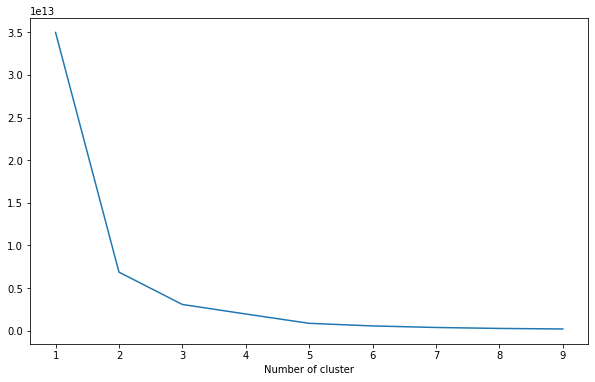

In [141]:
from sklearn.cluster import KMeans

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

# Elbow method is employed on TotalProfit column to determine optimal number of clusters we can divide data into
sse={}
tx_avg_sales = customer_data[['TotalProfit']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_avg_sales)
    tx_avg_sales["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In determining the optimal number of clusters for the data set based on Total Profit, the k value at the 'elbow' that is the point after which inertia decreases at a linear rate is 5. Thus for the given data, we conclude that the optimal number of clusters for the data is 5.

In [142]:
#build 5 clusters for average sales amount and add it to dataframe
kmeans = KMeans(n_clusters = 5)
kmeans.fit(customer_data[['TotalProfit']])
customer_data['MonetaryCluster'] = kmeans.predict(customer_data[['TotalProfit']])

customer_data = order_cluster('MonetaryCluster', 'TotalProfit', customer_data, False)

# View details of each cluster constructed for Total Profit
customer_data.groupby('MonetaryCluster')['TotalProfit'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,2.0,3.202617e+06,191837.349826,3.066967e+06,3.134792e+06,3.202617e+06,3.270442e+06,3.338266e+06
1,2.0,2.145187e+06,4102.199949,2.142286e+06,2.143737e+06,2.145187e+06,2.146637e+06,2.148088e+06
2,8.0,6.855031e+05,196768.673229,4.833857e+05,5.146714e+05,6.734850e+05,7.593180e+05,1.033117e+06
3,40.0,1.927600e+05,75332.231022,1.063638e+05,1.399005e+05,1.682255e+05,2.282585e+05,4.024750e+05
4,1352.0,9.355943e+03,15389.533745,0.000000e+00,7.453035e+02,3.181371e+03,1.005016e+04,9.896466e+04


The table above gives statistical data about the each of the 5 clusters constructed when the fit model is used to predict the cluster for each data point. Customers with a lower Monetary Cluster score are  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

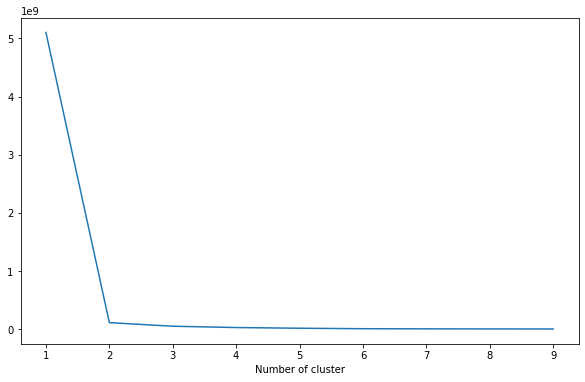

In [143]:
# Elbow method is employed on Frequency column to determine optimal number of clusters we can divide data into
sse={}
tx_avg_sales = customer_data[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_avg_sales)
    tx_avg_sales["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [144]:
#build 3 clusters for fequency and add it to dataframe
kmeans = KMeans(n_clusters = 3)
kmeans.fit(customer_data[['Frequency']])
customer_data['FrequencyCluster'] = kmeans.predict(customer_data[['Frequency']])

customer_data = order_cluster('FrequencyCluster', 'Frequency', customer_data, False)

# View details of each cluster constructed
customer_data.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1.0,70778.000000,NaN,70778.0,70778.0,70778.0,70778.0,70778.0
1,5.0,3623.800000,1954.981509,1998.0,2681.0,2877.0,3593.0,6970.0
2,1398.0,89.280401,156.338706,1.0,10.0,34.0,104.0,1592.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

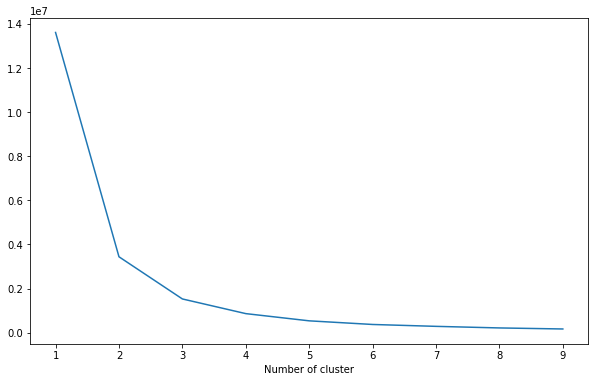

In [145]:
# Elbow method is employed on Recency column to determine optimal number of clusters we can divide data into
sse={}
tx_rec = customer_data[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_rec)
    tx_rec["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [146]:
#build 4 clusters for Recency column and add score to dataframe
kmeans = KMeans(n_clusters = 4)
kmeans.fit(customer_data[['Recency']])
customer_data['RecencyCluster'] = kmeans.predict(customer_data[['Recency']])

customer_data = order_cluster('RecencyCluster', 'Recency', customer_data, True)

# View details of each cluster constructed
customer_data.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1105.0,11.233484,13.758520,0.0,0.00,6.0,17.0,56.0
1,194.0,105.793814,36.724697,59.0,75.00,96.5,132.5,189.0
2,69.0,274.521739,55.915011,192.0,224.00,266.0,328.0,378.0
3,36.0,491.138889,72.105935,391.0,428.25,489.0,535.5,630.0


In [147]:
# Calcualte Overall Score
customer_data['OverallScore'] = customer_data['RecencyCluster'] + customer_data['FrequencyCluster'] + customer_data['MonetaryCluster'] 
customer_data.groupby('OverallScore')['TotalProfit','Frequency','Recency'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,TotalProfit,Frequency,Recency
OverallScore,,,
0,3.066967e+06,70778.000000,0.000000
2,3.338266e+06,984.000000,0.000000
3,1.727760e+06,2447.666667,2.333333
4,5.175804e+05,1010.100000,5.900000
5,1.855567e+05,334.085714,4.085714
6,1.142975e+04,104.858089,11.687796
7,5.005576e+03,8.989637,106.818653
8,3.101289e+03,2.882353,275.000000
9,6.181194e+02,1.277778,491.138889


In [148]:
customer_data['Cluster'] = 'Low-Value'
customer_data.loc[customer_data['OverallScore'] == 4, 'Cluster'] = 'Mid-Value' 
customer_data.loc[customer_data['OverallScore'] == 5,'Cluster'] = 'Mid-Value' 
customer_data.loc[customer_data['OverallScore'] == 6,'Cluster'] = 'Mid-Value' 
customer_data.loc[customer_data['OverallScore'] < 4,'Cluster'] = 'High-Value' 

In [149]:
customer_data.head()

,CustomerCode,AvgSales,AvgProfitPercentage,AvgProfit,Frequency,LatestPurchaseDate,TotalProfit,Recency,MonetaryCluster,FrequencyCluster,RecencyCluster,OverallScore,Cluster
0,A3RD01-3RD AVENUE HOLDINGS (PTY)LTD,2271.309027,20.640626,308.881363,113,2019-09-30,34903.593998,0,4,2,0,6,Mid-Value
1,A5DS01-5D STATIONERY,4176.135278,10.449052,213.072504,72,2019-09-16,15341.220300,14,4,2,0,6,Mid-Value
2,A89F01-89 FIFTY (PTY)LTD,907.554423,14.569066,94.173591,104,2019-09-30,9794.053500,0,4,2,0,6,Mid-Value
3,AAP001-AA Professional Services North - FTN,186.870427,17.560442,20.637507,117,2019-09-30,2414.588300,0,4,2,0,6,Mid-Value
4,AAR001-AARINVEST LIFE (PTY) LTD - COD,238.600714,26.179577,24.229350,14,2019-09-02,339.210900,28,4,2,0,6,Mid-Value


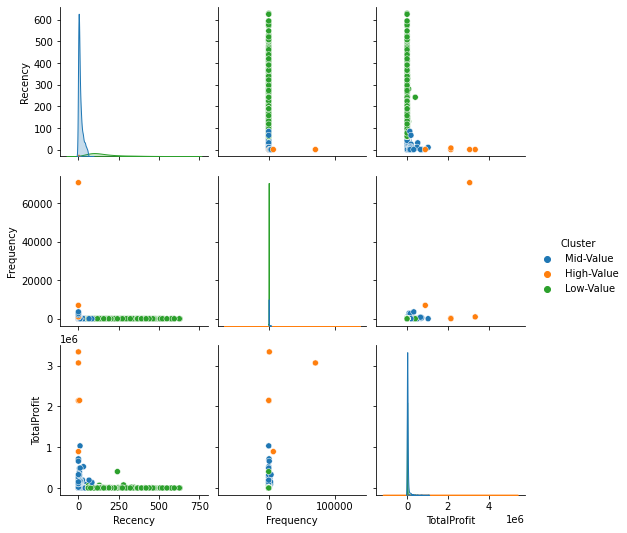

In [150]:
sns.pairplot(customer_data, vars=["Recency", "Frequency", "TotalProfit"],hue="Cluster")

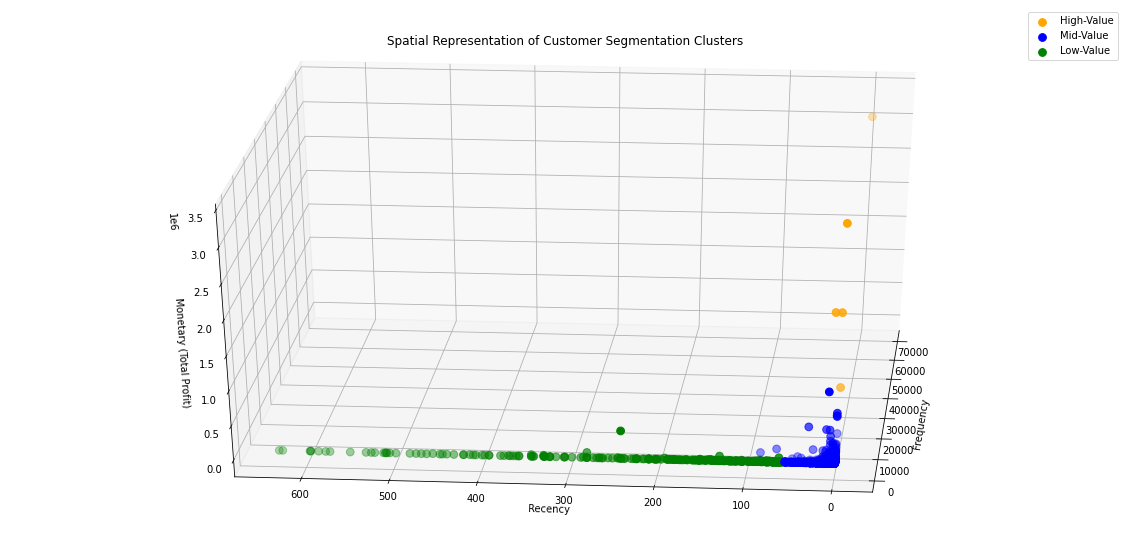

In [151]:
# 3D Visualization plot showing clusters
high = customer_data.query("Cluster == 'High-Value'")
mid = customer_data.query("Cluster == 'Mid-Value'")
low = customer_data.query("Cluster == 'Low-Value'")

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(high['Frequency'], high['Recency'], high['TotalProfit'], c='orange', s=60, label="High-Value")
ax.scatter(mid['Frequency'], mid['Recency'], mid['TotalProfit'], c='blue', s=60, label="Mid-Value")
ax.scatter(low['Frequency'], low['Recency'], low['TotalProfit'], c='green', s=60, label="Low-Value")

ax.view_init(30, 185)
plt.xlabel("Frequency")
plt.ylabel("Recency")
ax.set_zlabel('Monetary (Total Profit)')
plt.title("Spatial Representation of Customer Segmentation Clusters")
plt.legend()
plt.show()


**Model Evaluation**

In evaluating the model, the  DB Index is calculated for number of clusters 'k' ranging from 2 to 10. This is done to determine the optimum number of clusters for the data set.






In [152]:

from sklearn import datasets 
from sklearn.metrics import davies_bouldin_score 
from sklearn.datasets.samples_generator import make_blobs

X = customer_data[['Recency', 'Frequency', 'TotalProfit']].copy()

DBIndex_Values = dict()
  
for i in range (2, 11):

  X, y_true = make_blobs(n_samples=300, centers=i,  
                        cluster_std=0.50, random_state=0) 
  # K-Means 
  kmeans = KMeans(n_clusters=i, random_state=1).fit(X) 
    
  # we store the cluster labels 
  labels = kmeans.labels_ 
    
  DBIndex_Values[i] = davies_bouldin_score(X, labels)

  #print(davies_bouldin_score(X, labels)) 

#print(DBIndex_Values) 

df = pd.DataFrame(DBIndex_Values.items(), columns=['no_of_clusters(k)', 'DB_Index(DBI)'])

df.head(10)

,no_of_clusters(k),DB_Index(DBI)
0,2,0.339634
1,3,0.398786
2,4,0.366288
3,5,0.323660
4,6,0.352292
5,7,0.391645
6,8,0.356310
7,9,0.325421
8,10,0.329689


The table above shows that the when k = 3, the DBI is 0.398786. The desirable minimum DBI of 0.323660 is achieved when k = 5 as shown by the plot below:

Text(0.5, 1.0, 'DBI vs Number of Clusters')

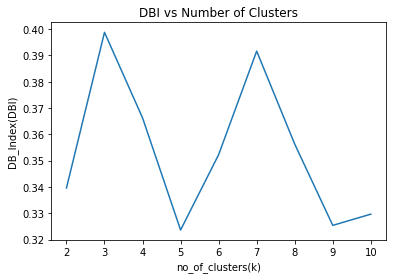

In [153]:
sns.lineplot(data = df,x="no_of_clusters(k)", y="DB_Index(DBI)").set_title('DBI vs Number of Clusters')

**Model Alteration**

The model is altered to make 5 rather that 3 segments and the results are visualized for comparison:


In [154]:
customer_data['Cluster_5'] = 'Low-Value'
customer_data.loc[customer_data['OverallScore'] == 8, 'Cluster_5'] = 'Mid-Low-Value' 
customer_data.loc[customer_data['OverallScore'] == 7,'Cluster_5'] = 'Mid-Low-Value' 
customer_data.loc[customer_data['OverallScore'] == 6,'Cluster_5'] = 'Mid-Value' 
customer_data.loc[customer_data['OverallScore'] == 5,'Cluster_5'] = 'Mid-Value' 
customer_data.loc[customer_data['OverallScore'] == 4,'Cluster_5'] = 'Mid-High-Value' 
customer_data.loc[customer_data['OverallScore'] == 3,'Cluster_5'] = 'Mid-High-Value' 
customer_data.loc[customer_data['OverallScore'] < 3,'Cluster_5'] = 'High-Value' 

customer_data.head()

,CustomerCode,AvgSales,AvgProfitPercentage,AvgProfit,Frequency,LatestPurchaseDate,TotalProfit,Recency,MonetaryCluster,FrequencyCluster,RecencyCluster,OverallScore,Cluster,Cluster_5
0,A3RD01-3RD AVENUE HOLDINGS (PTY)LTD,2271.309027,20.640626,308.881363,113,2019-09-30,34903.593998,0,4,2,0,6,Mid-Value,Mid-Value
1,A5DS01-5D STATIONERY,4176.135278,10.449052,213.072504,72,2019-09-16,15341.220300,14,4,2,0,6,Mid-Value,Mid-Value
2,A89F01-89 FIFTY (PTY)LTD,907.554423,14.569066,94.173591,104,2019-09-30,9794.053500,0,4,2,0,6,Mid-Value,Mid-Value
3,AAP001-AA Professional Services North - FTN,186.870427,17.560442,20.637507,117,2019-09-30,2414.588300,0,4,2,0,6,Mid-Value,Mid-Value
4,AAR001-AARINVEST LIFE (PTY) LTD - COD,238.600714,26.179577,24.229350,14,2019-09-02,339.210900,28,4,2,0,6,Mid-Value,Mid-Value


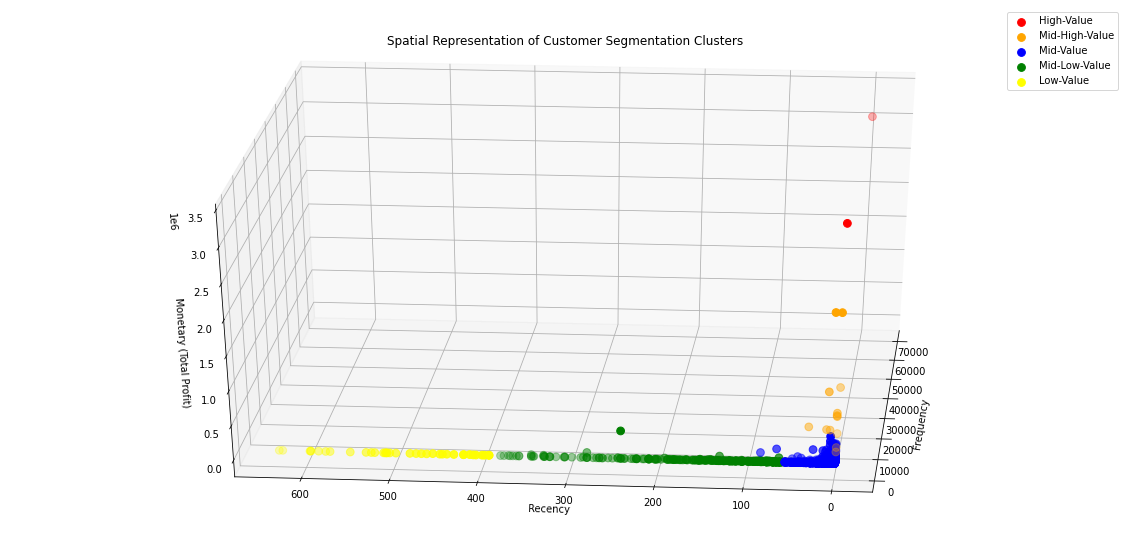

In [155]:
# 3D Visualization plot showing clusters
high = customer_data.query("Cluster_5 == 'High-Value'")
mid_high = customer_data.query("Cluster_5 == 'Mid-High-Value'")
mid = customer_data.query("Cluster_5 == 'Mid-Value'")
mid_low = customer_data.query("Cluster_5 == 'Mid-Low-Value'")
low = customer_data.query("Cluster_5 == 'Low-Value'")

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(high['Frequency'], high['Recency'], high['TotalProfit'], c='red', s=60, label="High-Value")
ax.scatter(mid_high['Frequency'], mid_high['Recency'], mid_high['TotalProfit'], c='orange', s=60, label="Mid-High-Value")
ax.scatter(mid['Frequency'], mid['Recency'], mid['TotalProfit'], c='blue', s=60, label="Mid-Value")
ax.scatter(mid_low['Frequency'], mid_low['Recency'], mid_low['TotalProfit'], c='green', s=60, label="Mid-Low-Value")
ax.scatter(low['Frequency'], low['Recency'], low['TotalProfit'], c='yellow', s=60, label="Low-Value")

ax.view_init(30, 185)
plt.xlabel("Frequency")
plt.ylabel("Recency")
ax.set_zlabel('Monetary (Total Profit)')
plt.title("Spatial Representation of Customer Segmentation Clusters")
plt.legend()
plt.show()